### About this result

Our training procedure is monitored with `WandbLogger`. This code retrieves the training results using `wandb` `API`.

- Seaborn error options, see [sns.errorbar](https://seaborn.pydata.org/tutorial/error_bars.html)

In [1]:
from collections import defaultdict
from functools import reduce
from itertools import product
import json

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tqdm
import wandb

import g_main

sns.set_theme()

api = wandb.Api()

with open("config.json", "r") as json_file:
    config = json.load(json_file)

### Setup counters to check the number of training results.

In [2]:
# Range of random seeds.
rnd_seed_range = range(20)

# Date time id of the training (not exact running time dates).
result_date = ["20240114", "20240116", "20240201"]

def check(run: wandb.run):
    """Function for checking the run configuration.

    Args:
        run : wandb.run
            One of the `run` object from `api.runs()`.
    
    Returns:
        Boolean: whether the run is in target training configurations.
    """

    # Check the run state.
    if run.state != "finished":
        return False

    # Check whether the `run` is in the correct date time.
    reduce_func = lambda date_bool, date: date_bool or (date in run.name)
    check_date = reduce(reduce_func, [False] + result_date)

    # Check whether the training configuration is correct.
    check_ml = (run.summary["epoch"] in [30, 60]) & (run.config["lr"] == 1E-3)

    # Check random seed.
    check_rnd_seed = (run.config["rnd_seed"]) in rnd_seed_range

    return check_date and check_ml and check_rnd_seed

# Counter for different model runs.
counter_dict = defaultdict(int)

for run in api.runs(f"{config['wandb_account']}/{config['wandb_project']}"):
    
    # Check run configuration.
    if not check(run):
        continue
        
    # Additional check for quantum (other configurations have been tested).
    if ("QuantumRotQCGNN" in run.name) and ("gl1" not in run.name):
        continue
    
    # Add corresponding counter.
    model = run.name.split("-")[0] + "-" + run.config["abbrev"]
    counter_dict[model] += 1

# Print out counters.
for key, value in counter_dict.items():
    assert value in [10, 20], f"Check {key} {value}/{len(rnd_seed_range)}"
    print(key, value)

ClassicalMLP_go7_gh7_gl2_mh0_ml0_add-TT-QCD 20
ClassicalMLP_go5_gh5_gl2_mh0_ml0_add-TT-QCD 20
ClassicalMLP_go3_gh3_gl2_mh0_ml0_add-TT-QCD 20
ClassicalMLP_go7_gh7_gl2_mh0_ml0_add-BB-QCD 20
ClassicalMLP_go5_gh5_gl2_mh0_ml0_add-BB-QCD 20
ClassicalMLP_go3_gh3_gl2_mh0_ml0_add-BB-QCD 20
QCGNN_IX_qidx4_qnn7_gl1_gr7_SUM-TT-QCD 10
QCGNN_IX_qidx4_qnn3_gl1_gr3_SUM-TT-QCD 10
QCGNN_IX_qidx4_qnn7_gl1_gr7_SUM-BB-QCD 10
QCGNN_IX_qidx4_qnn3_gl1_gr3_SUM-BB-QCD 10
QCGNN_IX_qidx4_qnn5_gl1_gr5_SUM-TT-QCD 10
QCGNN_IX_qidx4_qnn5_gl1_gr5_SUM-BB-QCD 10


### Retrieve training results on `wandb` and store in a `pandas` data frame

In [3]:
# Data frame for storing results.
df = pd.DataFrame()

# Setup a tqdm for monitoring process.
wandb_runs = api.runs(f"{config['wandb_account']}/{config['wandb_project']}")
for run in tqdm.tqdm(wandb_runs):

    # Check whether the run is our target training result.
    if not check(run):
        continue

    # Select only a subset of random seeds.
    if (run.config["rnd_seed"] % 10) not in rnd_seed_range:
        continue

    # Since the validation results have different steps than training results, 
    # they should be export independently. Otherwise pandas cannot be created
    # in correct shape.
    hist_train = run.history(
        keys=[
            "epoch", "epoch_time",
            "train_acc_epoch", "train_loss_epoch", "train_roc_auc"
        ],
        x_axis="epoch"
    )
    hist_valid = run.history(
        keys=["valid_acc_epoch", "val_roc_auc"],
        x_axis="epoch"
    )

    # This training result data frame.
    temp_frame = pd.concat(
        [hist_train,  hist_valid[["valid_acc_epoch", "val_roc_auc"]]], axis=1)

    # Set pandas columns of keys (features) we want.
    config_keys = ["model_name", "abbrev", "rnd_seed"]

    if "ClassicalMLP" in run.name:
        config_keys += ["gnn_hidden", "gnn_out"]
        temp_frame["legend"] = f"C(D={run.config['gnn_out']})"

    elif g_main.QCGNN.__name__ in run.name:
        if "gl1" not in run.name:
            continue
        config_keys += ["gnn_nn_qubits", "gnn_reupload", "gnn_layers"]
        temp_frame["legend"] = f"Q(D={run.config['gnn_nn_qubits']})"

    for key in config_keys:
        temp_frame[key] = run.config[key]
    
    # Concatenate this training result to total result data frame (df).
    df = pd.concat([df, temp_frame], axis=0)

100%|██████████| 500/500 [02:57<00:00,  2.82it/s]


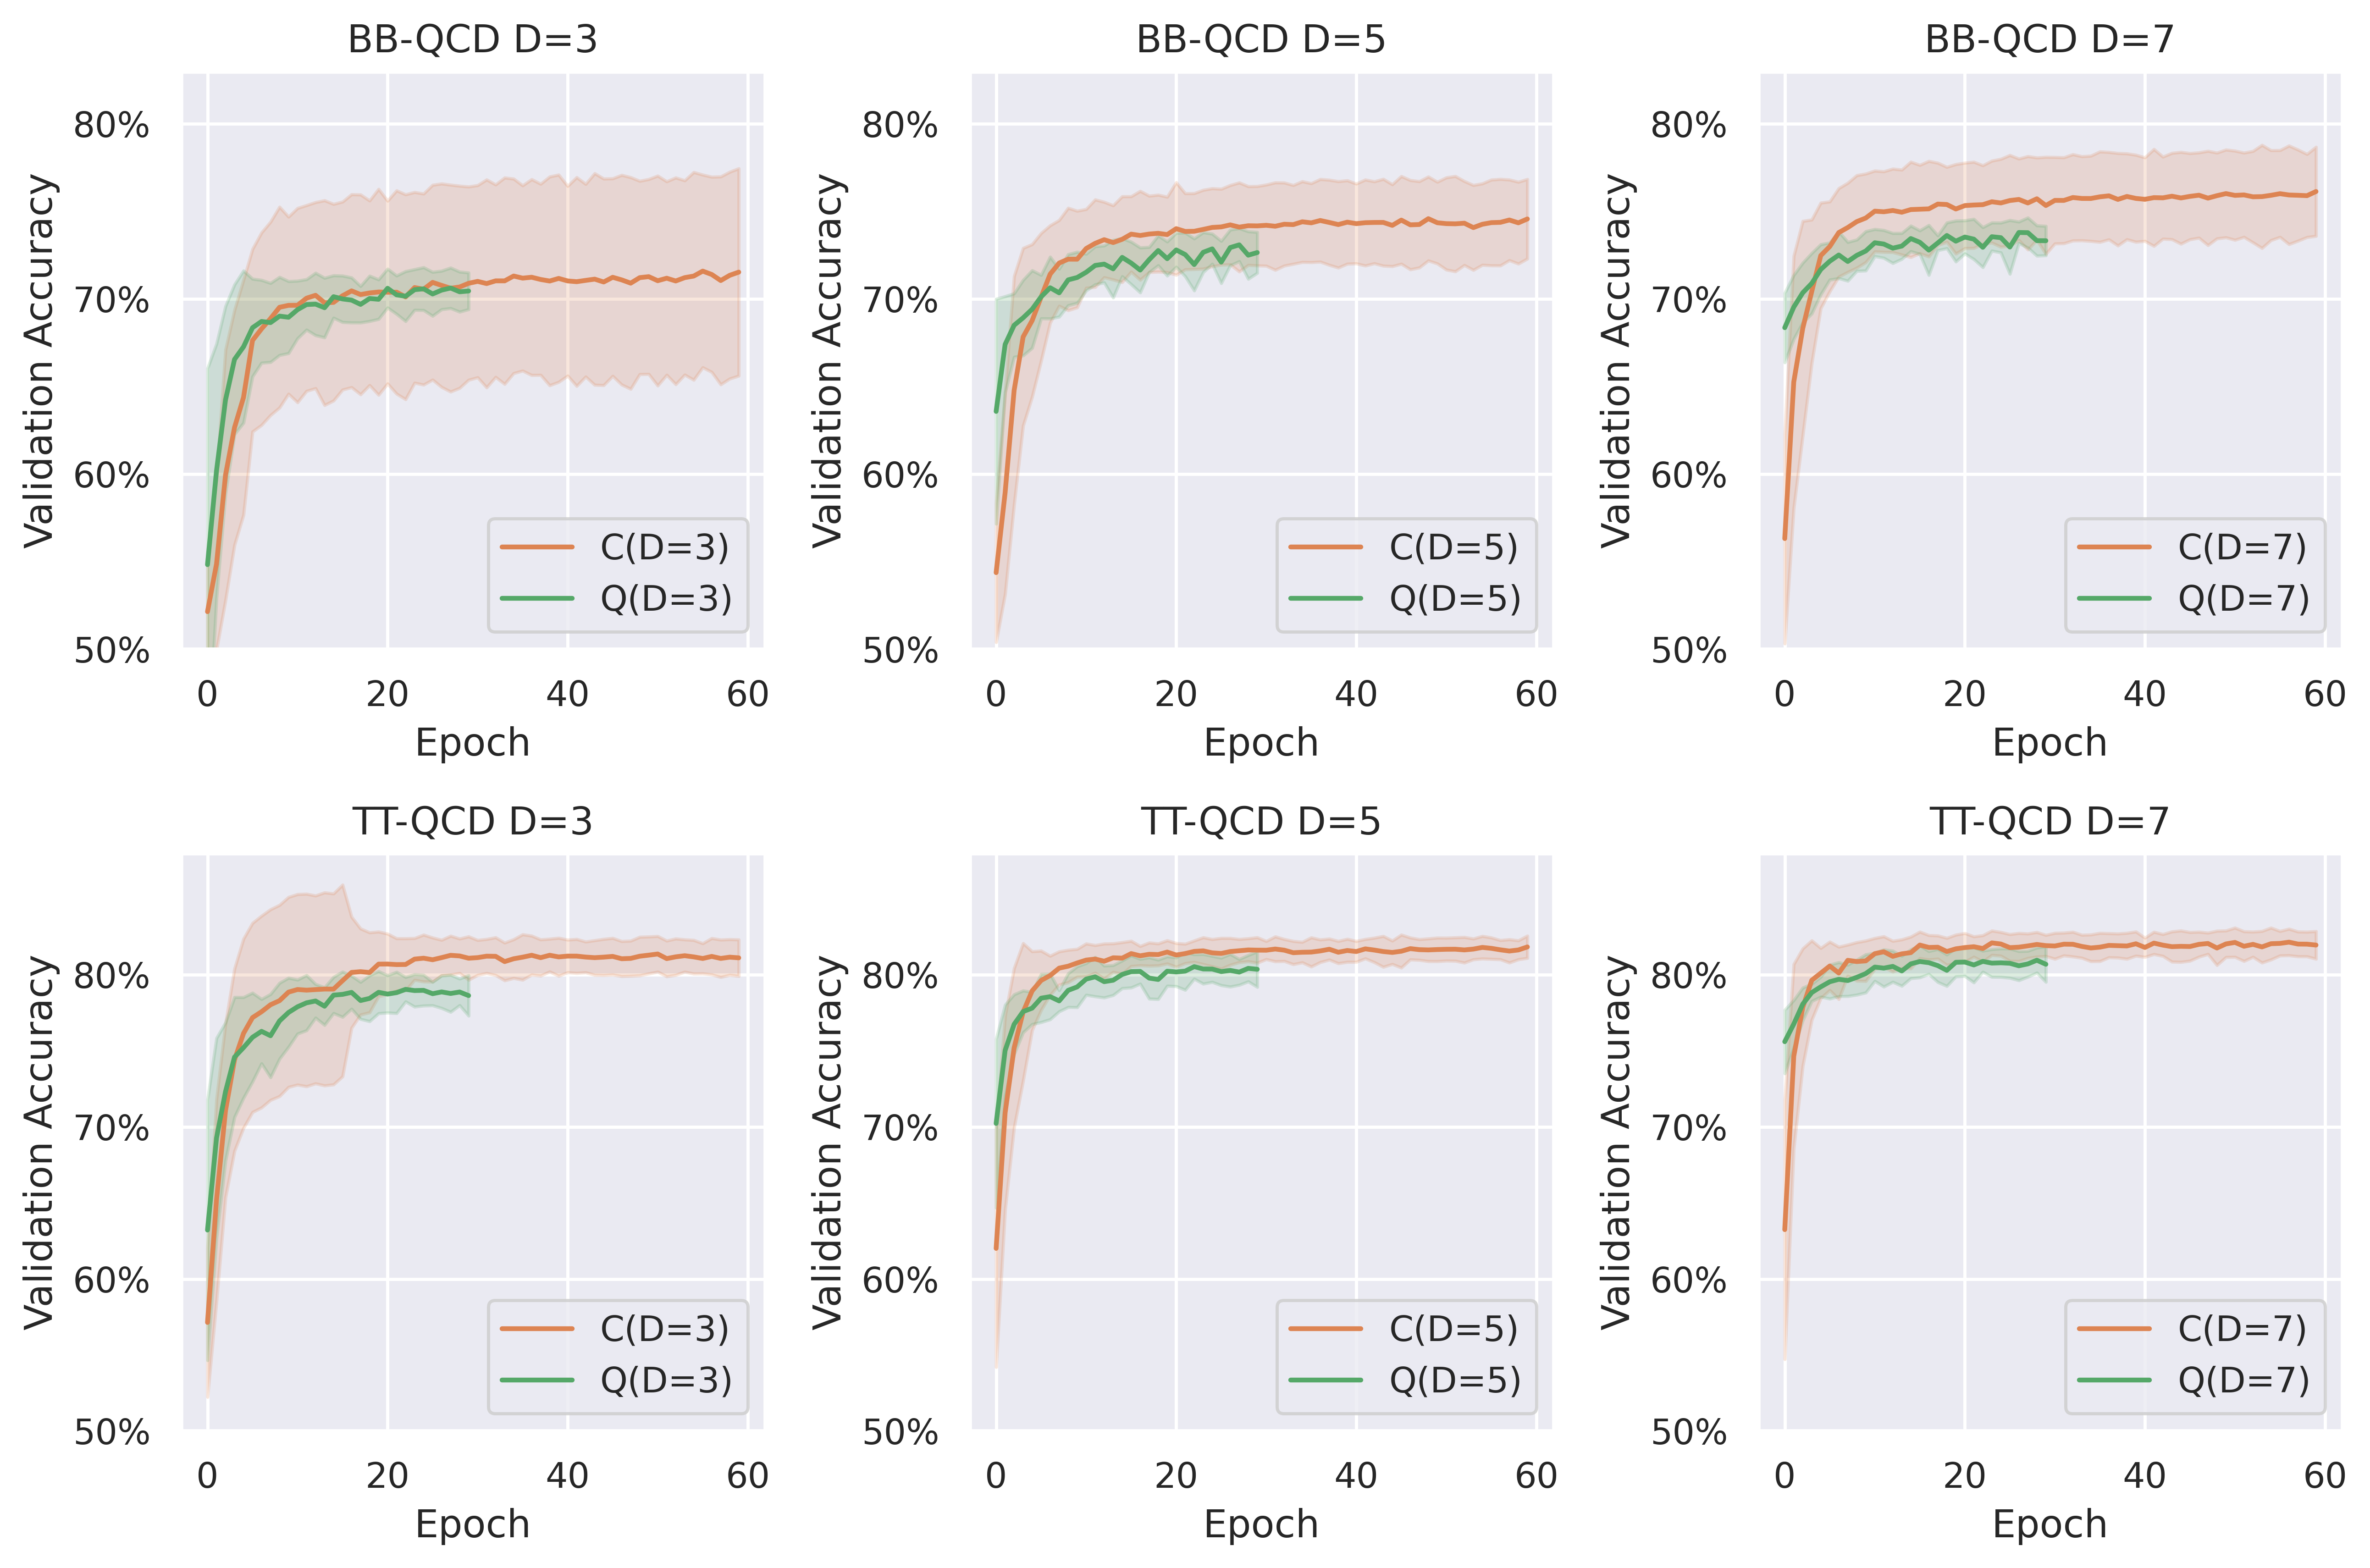

In [4]:
# Channel abbreviations list.
abbrev_list = ["BB-QCD", "TT-QCD"]

# Model dimension list.
dim_list = [3, 5, 7]

# Figure settings.
num_row = len(abbrev_list)
num_col = len(dim_list)
width, height = 3.5 * num_col, 3.5 * num_row
fig, ax = plt.subplots(num_row, num_col, figsize=(width, height), dpi=500)
color_palette = {
    # The key will correspond to seaborn `hue`.
    "C(D=1024)":"C0", "C(D=1024)":"C0",
    "C(D=3)":"C1", "C(D=5)":"C1", "C(D=7)":"C1",
    "C(D=3)":"C1", "C(D=5)":"C1", "C(D=7)":"C1",
    "Q(D=3)":"C2", "Q(D=5)":"C2", "Q(D=7)":"C2",
    "Q(D=3)":"C2", "Q(D=5)":"C2", "Q(D=7)":"C2",
}

for row, col in product(range(num_row), range(num_col)):
    abbrev = abbrev_list[row]
    dim = dim_list[col]

    is_abbrev = (df["abbrev"] == abbrev)
    is_classical = (df["gnn_out"] == 1024) | (df["gnn_out"] == dim)
    is_quantum = (df["gnn_nn_qubits"] == dim) & (df["gnn_reupload"] == dim)
    index = is_abbrev & (is_classical | is_quantum)

    # # Plot training data procedure and result.
    # sns.lineplot(
    #     data=df[index],
    #     x="epoch",
    #     y="train_acc_epoch",
    #     hue="legend",
    #     ax=ax[row][col],
    #     palette=color_palette,
    #     err_style=None,
    #     legend=False,
    #     linestyle='--'
    # )

    # Plot testing (validation) data procedure and result.
    sns.lineplot(
        data=df[index],
        x="epoch",
        y="valid_acc_epoch",
        hue="legend",
        ax=ax[row][col],
        palette=color_palette,
        # errorbar=None,
        errorbar=("sd", 1),
    )

    # Setup labels and titles.
    ax[row][col].set_xlabel("Epoch")
    ax[row][col].set_ylabel("Validation Accuracy")
    ax[row][col].set_title(f"{abbrev_list[row]} D={dim_list[col]}")

    # Manually set figures y-axis range (limit).
    if abbrev == "BB-QCD":
        ax[row][col].set_ylim(0.50, 0.83)
    elif abbrev == "TT-QCD":
        ax[row][col].set_ylim(0.50, 0.88)
    ax[row][col].set_yticks([0.5, 0.6, 0.7, 0.8], labels=["50%", "60%", "70%", "80%"])

    # Move the legend bot to bottom right.
    sns.move_legend(ax[row][col], "lower right", title=None)

    plt.tight_layout()
    plt.savefig(f"{config['figures_dir']}/result_sim.png")